In [2]:
import pandas as pd
import numpy as np
import librosa as lr
import os
import pydot
import graphviz


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM
from keras.utils import plot_model, to_categorical
from os.path import join

2023-04-12 19:36:38.089781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 19:36:38.259776: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-12 19:36:38.289739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-12 19:36:38.289750: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [214]:
def feature_extraction(path):
    audio, sample_rate = lr.load(path, mono = True)
    mfcc = np.mean(lr.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 120), axis = 1)
    feature_array = np.array(mfcc)
    return feature_array

In [215]:
path = '/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/audio_4kHz_filtered'
audio_files_paths = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.wav')]
patient_diagnosis = pd.read_csv('/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/patient_diagnosis.csv', names = ['pid', 'disease'])
labels = []
features = []
for file in audio_files_paths:
    pid = int(file.split('/')[-1].split('_')[0])
    features.append(feature_extraction(file))
    labels.append(patient_diagnosis.loc[patient_diagnosis["pid"] == pid, "disease"].iloc[0]) # Get disease for corresponding pid
features_final = np.array(features)
labels_final = np.array(labels)

In [216]:
disease_dict = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

labels_new = [disease_dict[d] for d in labels_final]
labels = np.array(labels_new)
features = np.array(features)

In [217]:
for i in range(len(labels_new)):
    if labels_new[i] > 1:
        labels_new[i] = 2

In [218]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

label_encoder.fit(labels_new)
numeric_labels = label_encoder.transform(labels_new)
labels = to_categorical(numeric_labels)

labels.shape


(920, 3)

In [219]:
X_train, X_val_test, y_train, y_val_test = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.3, random_state=42)


In [87]:
y_train.shape

(644, 3)

In [88]:
from imblearn.over_sampling import SMOTE
y_int = np.argmax(y_train, axis=1)

# Step 2: Apply SMOTE on your input data and target labels
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_int)

# Step 3: Convert your target labels back into one-hot encoded format
num_classes = len(np.unique(y_int))
y_resampled = np.eye(num_classes)[y_resampled]

In [220]:
X_train = np.reshape(X_resampled, (X_resampled.shape[0], X_resampled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],  1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  1))


In [90]:
X_test.shape

(83, 120, 1)

In [225]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.00001)

model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(120, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size = 2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))   
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, batch_size = 64, verbose = 1)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 116, 64)           384       
                                                                 
 conv1d_121 (Conv1D)         (None, 112, 128)          41088     
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 56, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_122 (Conv1D)         (None, 52, 256)           164096    
                                                                 
 max_pooling1d_81 (MaxPoolin  (None, 26, 256)          0         
 g1D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 26, 256)         

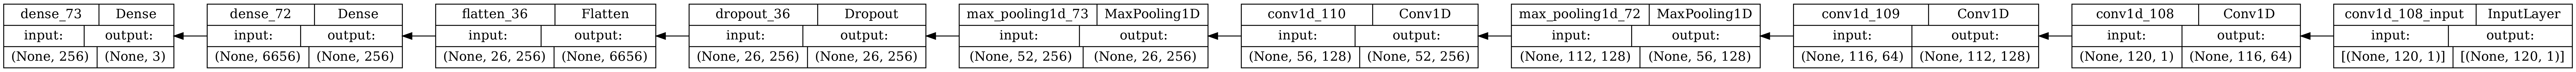

In [207]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='history.png', show_shapes=True, show_layer_names=True, dpi = 300, rankdir='RL')

Accuracy: 84%
Loss: 0.3129



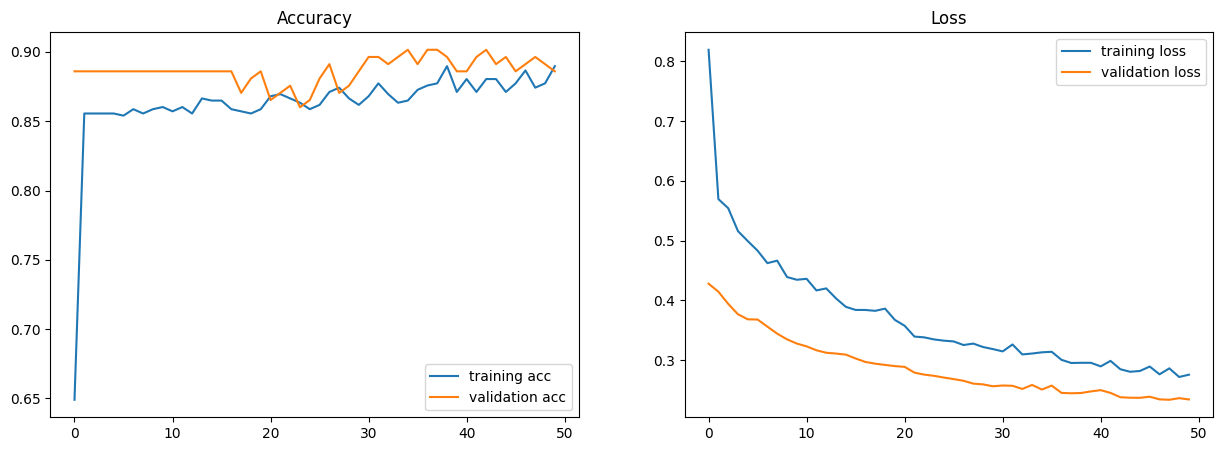

In [226]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()



In [229]:
train_loss, train_acc = model.evaluate(X_train, y_resampled)
print('Training Loss:', train_loss)
print('Training Accuracy:', train_acc)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Testing Loss:', test_loss)
print('Testing Accuracy:', test_acc)

21/21 [==============================] - 0s 4ms/step - loss: 0.2475 - accuracy: 0.8898
Training Loss: 0.24752533435821533
Training Accuracy: 0.8897515535354614
7/7 [==============================] - 0s 3ms/step - loss: 0.2345 - accuracy: 0.8860
Validation Loss: 0.23446211218833923
Validation Accuracy: 0.8860103487968445
3/3 [==============================] - 0s 5ms/step - loss: 0.3129 - accuracy: 0.8434
Testing Loss: 0.31293371319770813
Testing Accuracy: 0.8433734774589539


3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

        COPD       0.92      0.93      0.92        70
     Healthy       0.00      0.00      0.00         2
       Other       0.45      0.45      0.45        11

    accuracy                           0.84        83
   macro avg       0.46      0.46      0.46        83
weighted avg       0.83      0.84      0.84        83



<Axes: xlabel='Predicted', ylabel='Actual'>

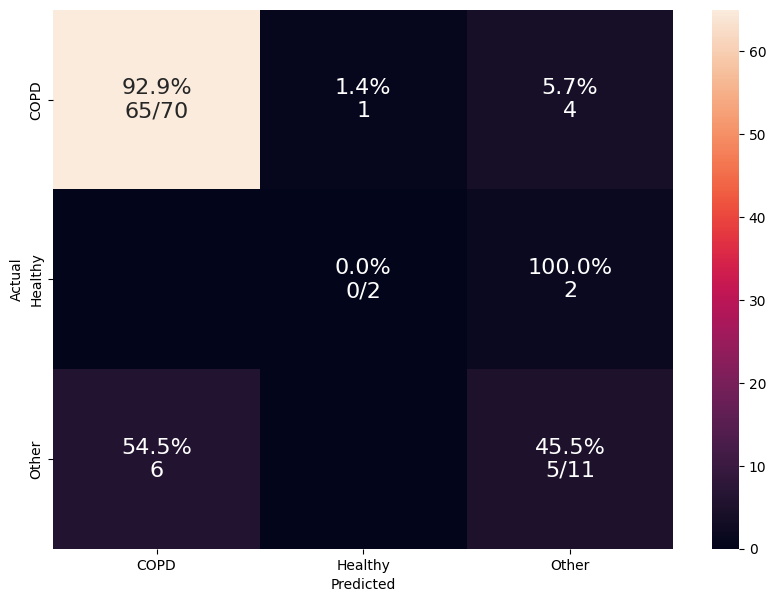

In [227]:
matrix_index = ["COPD", "Healthy", "Other"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='', annot_kws={"size": 16})



## External Validation

In [127]:
def load_audio_file_external (audio_file_path):
  audio, sample_rate = lr.load(path, mono = True)
  mfcc = np.mean(lr.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 120), axis = 1)
  feature_array = np.array(mfcc)
  return feature_array

In [196]:
path = '/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/external_validaton/D filter selected audio_our filter/'
audio_files_paths = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.wav')]
patient_diagnosis = pd.read_csv('/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/external_validaton/D filter selected.csv')
labels = []
features = []
for file in audio_files_paths:
    index = file.split('/')[-1]
    features.append(feature_extraction(file))
    labels.append(patient_diagnosis.loc[patient_diagnosis["File names"] == index, "Diagnosis"].iloc[0]) # Get disease for corresponding pid
features_final = np.array(features)

In [197]:
labels_final = []
for label in labels:
    if label == 'COPD':
        labels_final.append(0)
    elif label == 'N':
        labels_final.append(1)
    else:
        labels_final.append(2)
labels_final = np.array(labels_final)

In [198]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

# apply the random undersampling to the training data
features_final, labels = rus.fit_resample(features_final, labels_final)


In [199]:
features = np.reshape(features_final, (features_final.shape[0], features_final.shape[1], 1))

In [200]:
label_encoder = LabelEncoder()

label_encoder.fit(labels)
numeric_labels = label_encoder.transform(labels)
labels = to_categorical(labels)

In [201]:
test_loss, test_acc = model.evaluate(features, labels)
print('Testing Loss:', test_loss)
print('Testing Accuracy:', test_acc)

1/1 [==============================] - 0s 15ms/step - loss: 4.7160 - accuracy: 0.3333
Testing Loss: 4.715981483459473
Testing Accuracy: 0.3333333432674408


1/1 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

        COPD       0.33      1.00      0.50         8
     Healthy       0.00      0.00      0.00         8
       Other       0.00      0.00      0.00         8

    accuracy                           0.33        24
   macro avg       0.11      0.33      0.17        24
weighted avg       0.11      0.33      0.17        24



/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='Predicted', ylabel='Actual'>

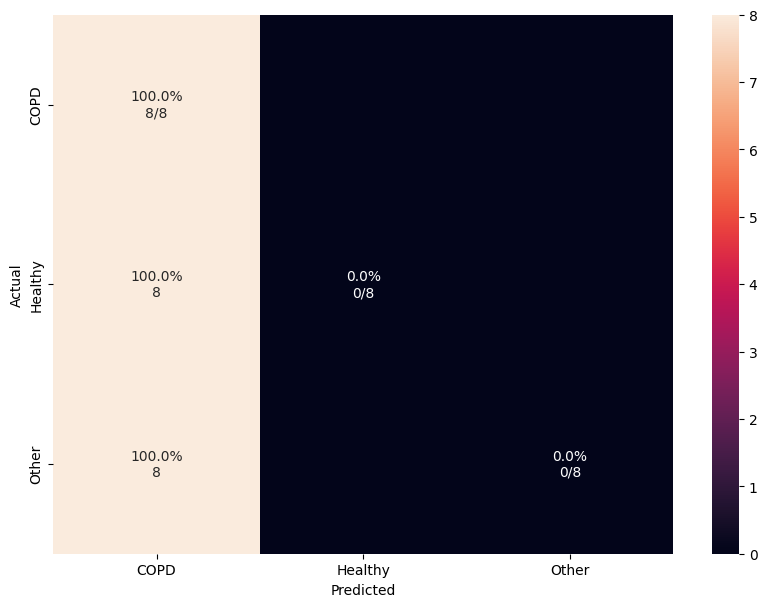

In [202]:
matrix_index = ["COPD", "Healthy", "Other"]

preds = model.predict(features)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(labels, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')
